# 傾向スコアマッチング

## ライブラリをインポート

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))
import urllib.request

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## サンプルデータの取得

In [2]:
def download_file(url, filepath):
    urllib.request.urlretrieve(url, filepath)

In [3]:
url = "https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv"
filepath = "../data/sample.csv"

if not os.path.exists(filepath):
    download_file(url, filepath)

raw_df = pd.read_csv(filepath)

In [4]:
print(f'データサイズ: {raw_df.shape[0]:,}')
raw_df.head()

データサイズ: 10,000


,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


手順

- 傾向スコアを求める
    - 傾向スコアの分布を確認
- 傾向スコアマッチングを行う
    - マッチング後の分布を確認
- 傾向スコアマッチング後のデータフレームを取得
- att, atu, ate, などの指標を元に介入による影響を分析

In [139]:
%load_ext autoreload
%autoreload
from libs import PropensityScoreMatching

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

In [141]:
treatment = 'cm_dummy'

model = LogisticRegression
params = {'solver': 'lbfgs', 'max_iter': 200, 'random_state': 42}
scaler = preprocessing.MinMaxScaler()

pscore_model = PropensityScoreMatching(raw_df, treatment)
pscore_model.fit(model, params, scaler, n_fold=5)
transformed_df = pscore_model.predict()

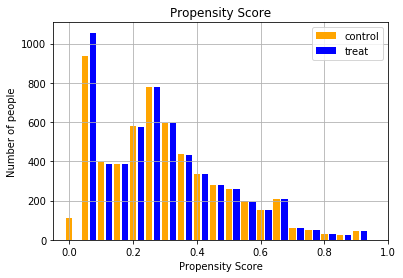

In [142]:
df = transformed_df

plt.title('Propensity Score')
plt.ylabel('Number of people')
plt.xlabel('Propensity Score')
plt.xlim(-0.05, 1.0)
df.loc[df['cm_dummy']==0, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='left', rwidth=0.4, color='orange', label='control')
df.loc[df['cm_dummy']==1, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

In [143]:
outcome = 'gamesecond'

att = pscore_model.att[outcome]
atu = pscore_model.atu[outcome]
ate = pscore_model.estimate_ate(outcome)
sem_zero, sem_one = pscore_model.estimate_sem(outcome)

print(f'CM接触者の Average {outcome}: {att:.2f} 秒　（標準誤差：{sem_one:.2f}）')
print(f'CM非接触者 Average {outcome}: {atu:.2f} 秒　（標準誤差：{sem_zero:.2f}）')
print(f'CM接触によるATE: {ate:.02f} 秒')

CM接触者の Average gamesecond: 7272.19 秒　（標準誤差：370.60）
CM非接触者 Average gamesecond: 3107.71 秒　（標準誤差：254.78）
CM接触によるATE: 4164.49 秒
